# W261 Final Project EDA

### Notebook Set-Up

In [5]:
# imports
import re
import time
import numpy as np
import pandas as pd
#from scipy.sparse import csr_matrix

import psycopg2
import psycopg2 # database
import json
from datetime import timedelta

#visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [4]:
#!pip install psycopg2-binary

    100% |################################| 2.7MB 13.7MB/s 
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [8]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "w261_finalproject"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

__`REMINDER:`__ If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

## Load Data

In [5]:
# make a data folder & download red & white wine files
!mkdir data
#data behind agreement
#!wget -q -O data/advertising.csv http://labs.criteo.com/2014/02/download-kaggle-display-advertising-challenge-dataset/

In [9]:
!head data/train.txt 

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16
0	2	0	44	1	102	8	2	2	4	1	1		4	68fd1e64	f0cf0024	6f67f7e5	41274cd7	25c83c98	fe6b92e5	922afcc0	0b153874	a73ee510	2b53e5fb	4f1b46f3	623049e6	d7020589	b28479f6	e6c5b5cd	c92f3b61	07c540c4	b04e4670	21ddcdc9	5840adea	60f6221e		3a171ecb	43f13e8b	e8b83407	731c3655
0	2	0	1	14	767	89	4	2	245	1	3	3	45	287e684f	0a519c5c	02cf9876	c18be181	25c83c98	7e0ccccf	c78204a1	0b153874	a73ee510	3b08e48b	5f5e6091	8fe001f4	aa655a2f	07d13a8f	6dc710ed	36103458	8efede7f	3412118d			e587c466	ad3062eb	3a171ecb	3b183c5c		
0		893			4392		0	0	0		0			68fd1e64	2c16a946	a9a87e68	2e17d6f6	25c83c98	fe6b92e5	2e8a689b	0b153874	a73ee510	efea433b	e51ddf94	a30567ca	3516f6e6	07d13a8f	18231224	52b8680f	1e88c74f	74ef3502			6b3a5ca6		3a171ecb	9117a34a		
0	3	-1		0	2	0	3	0	0	1	1		0	8

In [11]:
#header = !head -n 1 data/dac.tar/dac/train.txt
header = !head -n 1 data/train.txt
header = header[0]
header

'0\t1\t1\t5\t0\t1382\t4\t15\t2\t181\t1\t2\t\t2\t68fd1e64\t80e26c9b\tfb936136\t7b4723c4\t25c83c98\t7e0ccccf\tde7995b8\t1f89b562\ta73ee510\ta8cd5504\tb2cb9c98\t37c9c164\t2824a5f6\t1adce6ef\t8ba8b39a\t891b62e7\te5ba7672\tf54016b9\t21ddcdc9\tb1252a9d\t07b5194c\t\t3a171ecb\tc5c50484\te8b83407\t9727dd16'

In [12]:
header.split('\t')

['0',
 '1',
 '1',
 '5',
 '0',
 '1382',
 '4',
 '15',
 '2',
 '181',
 '1',
 '2',
 '',
 '2',
 '68fd1e64',
 '80e26c9b',
 'fb936136',
 '7b4723c4',
 '25c83c98',
 '7e0ccccf',
 'de7995b8',
 '1f89b562',
 'a73ee510',
 'a8cd5504',
 'b2cb9c98',
 '37c9c164',
 '2824a5f6',
 '1adce6ef',
 '8ba8b39a',
 '891b62e7',
 'e5ba7672',
 'f54016b9',
 '21ddcdc9',
 'b1252a9d',
 '07b5194c',
 '',
 '3a171ecb',
 'c5c50484',
 'e8b83407',
 '9727dd16']

In [13]:
header2 = !head -n 2 data/train.txt
header2 = header2[1]
np.array(header2.split("\t")[:14], dtype = np.float)

ValueError: could not convert string to float: 

In [14]:
original_trainRDD = sc.textFile('data/train.txt')
original_testRDD = sc.textFile('data/test.txt')

## Parse and Sample Training Data

In [15]:
def parse(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    raw_values = line.split('\t')
    label = [int(raw_values[0])]
    numerical_values = list(pd.Series(raw_values[1:14]).apply(pd.to_numeric))
    categorical_values = list([str(idx)+"_MISSINGVALUE" if str(value)=="" else str(idx)+"_"+str(value) for idx,value in enumerate(raw_values[14:])])
    return(numerical_values + categorical_values + label)

In [16]:
def parse_numbers(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    fields = np.array(line.split('\t')[:14])
    label,features = fields[0], fields[1:]
    return(features, label)

In [17]:
def parse_categories(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    fields = np.array(line.split('\t'))
    label,features = fields[0], fields[14:]
    return(features, label)

In [18]:
trainRDD, heldOutRDD = original_trainRDD.randomSplit([0.8,0.2], seed = 1)
print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 9167871 records for evaluation and assigned 36672746 for training.


In [19]:
numeric_trainRDDCached = trainRDD.map(parse_numbers).cache()
categorical_trainRDDCached = trainRDD.map(parse_categories).cache()

In [96]:
numeric_sample = np.array(numeric_trainRDDCached.map(lambda x: np.append(x[0], [x[1]])).takeSample(False, 5000))
numeric_sample_df = pd.DataFrame(np.array(numeric_sample))#, columns = FIELDS)

In [97]:
numeric_sample_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,0,8,1,1,0,4,12,237,1,3,0,0,1
1,6,215,22,1,14,62,28,49,140,1,3,0,1,0
2,1,244,2,1,427,5,53,5,25,1,10,,1,1
3,,38,4,,70935,179,0,8,89,,0,,,0
4,,-1,8,15,15804,88,18,26,86,,2,,15,0


In [98]:
categorical_sample = np.array(categorical_trainRDDCached.map(lambda x: np.append(x[0], [x[1]])).takeSample(False, 5000))
categorical_sample_df = pd.DataFrame(np.array(categorical_sample))#, columns = FIELDS)

In [99]:
categorical_sample_df.head()#26 features + label

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,68fd1e64,023a27f8,03c15597,3904e043,a9411994,7e0ccccf,5d87968e,ba7cbdc6,a73ee510,70ee1d85,...,59d746a3,,,5f24ddc8,c9d4222a,c7dc6720,b0253af9,,,1
1,05db9164,0468d672,003f419b,ff852091,4cf72387,7e0ccccf,22fd2464,5b392875,a73ee510,b5154b41,...,124c6b00,21ddcdc9,b1252a9d,3dd38d65,,32c7478e,c2fe6ca4,ea9a246c,0015d4de,0
2,05db9164,1cfdf714,06c60944,a425fe09,25c83c98,7e0ccccf,46fff0b1,0b153874,a73ee510,8d3ab9e3,...,e88ffc9d,5ad05719,a458ea53,5f8c4a3b,,3a171ecb,3fdb382b,cb079c2d,49d68486,0
3,68fd1e64,3f0d3f28,c2b2b3f5,77a160bd,25c83c98,fe6b92e5,c9f171f9,64523cfa,a73ee510,75d433aa,...,744ad4a0,,,a17a10b3,ad3062eb,3a171ecb,e5fca70a,,,1
4,05db9164,04e09220,f9aed79a,a1e6a194,25c83c98,7e0ccccf,a8280573,0b153874,a73ee510,3b08e48b,...,e161d23a,,,33c96fc7,,32c7478e,ded4aac9,,,1


## EDA for Numerical Values

In [100]:
numeric_sample_df = numeric_sample_df.apply(pd.to_numeric)

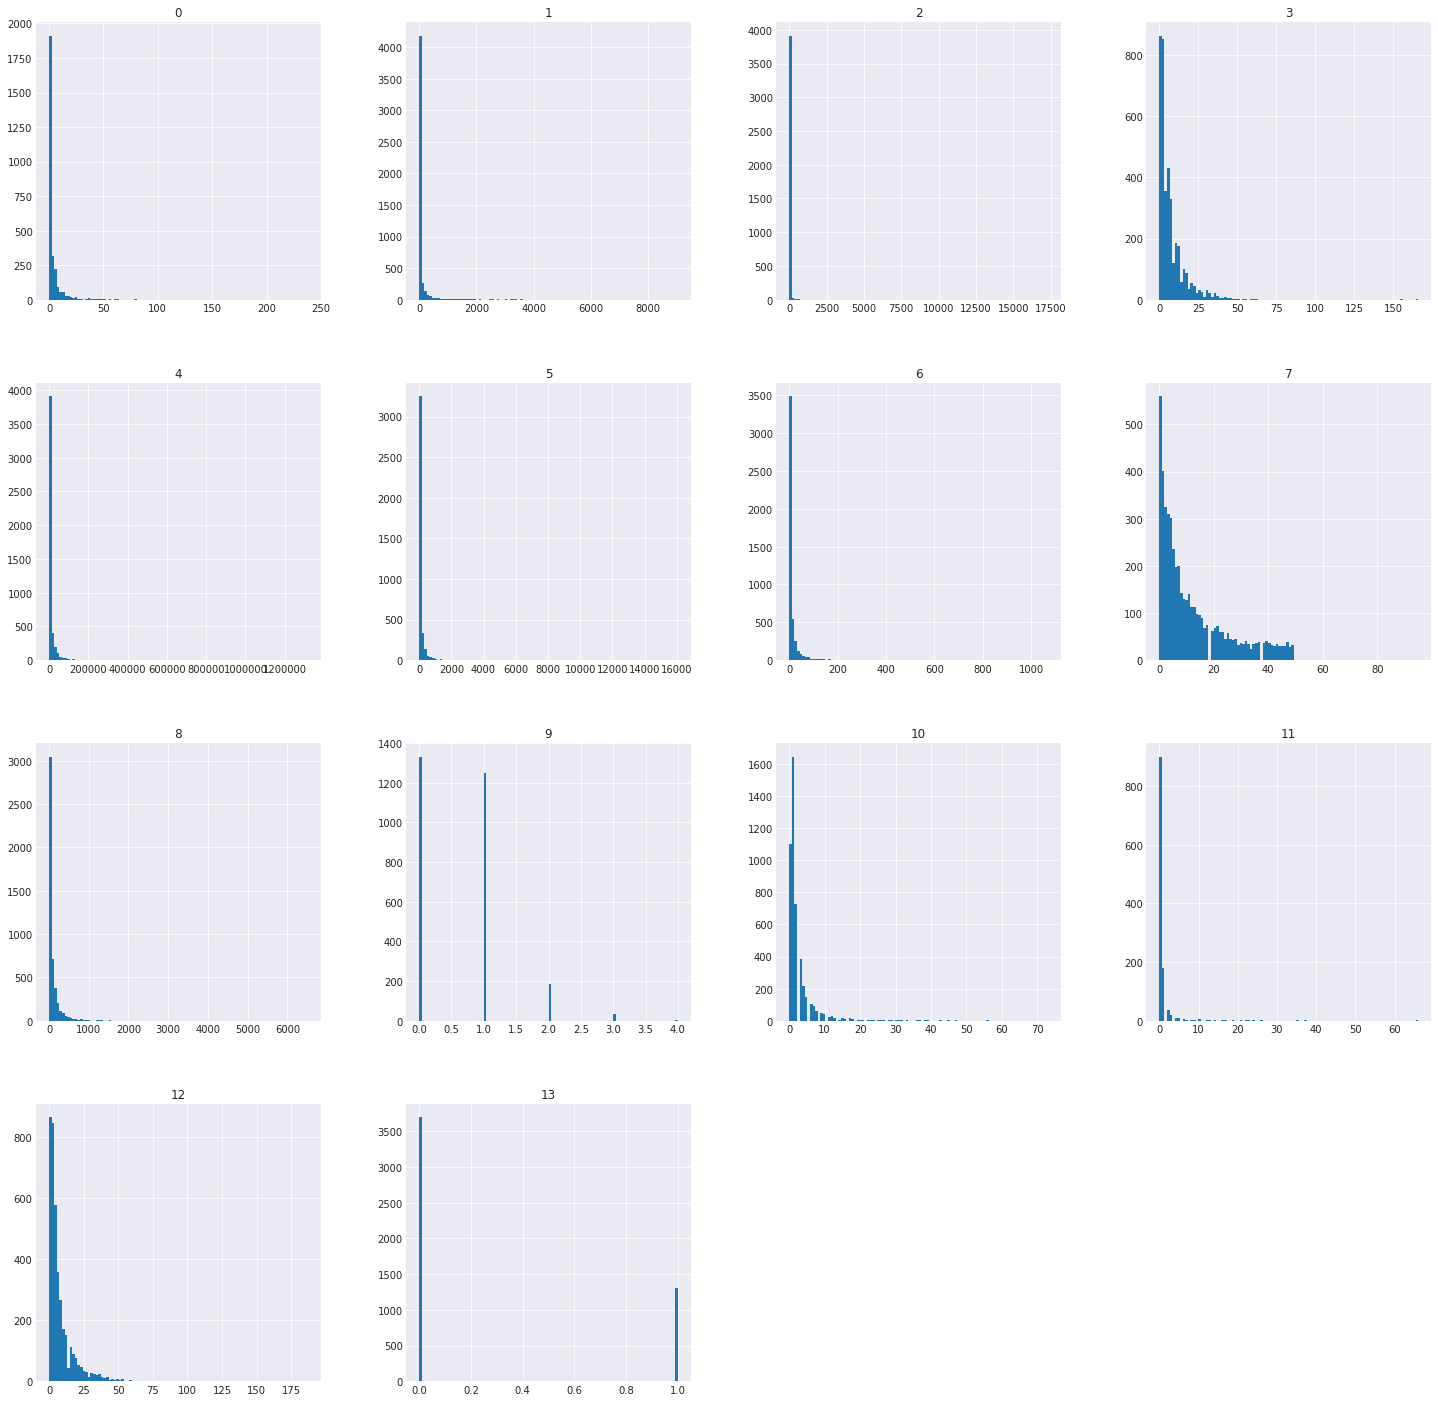

In [101]:
numeric_sample_df.hist(figsize=(25,25), bins=100)
plt.show()

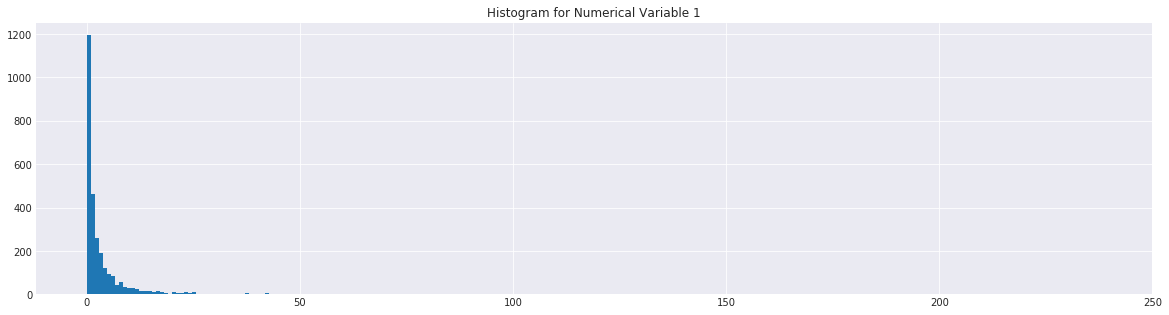

In [123]:
catVarNum = 0
numeric_sample_df[catVarNum].hist(figsize=(20,5), bins=250)
plt.title("Histogram for Numerical Variable " + str(catVarNum+1))
plt.show()

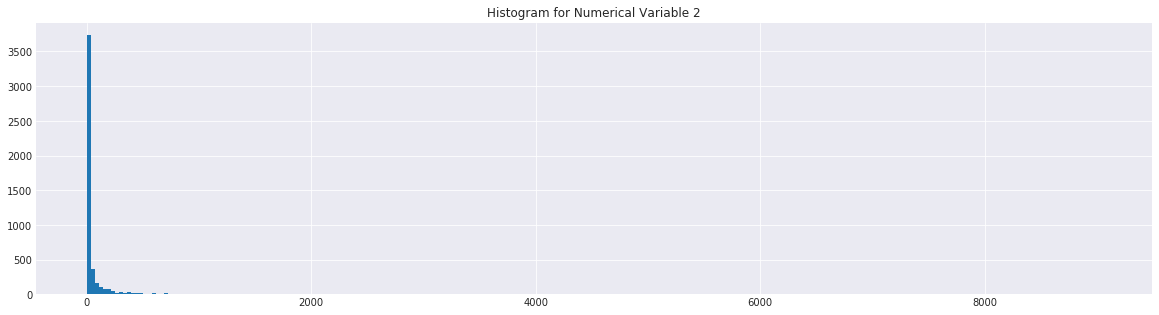

In [103]:
catVarNum = 1
numeric_sample_df[catVarNum].hist(figsize=(20,5), bins=250)
plt.title("Histogram for Numerical Variable " + str(catVarNum+1))
plt.show()
#bin 1: 0, bin 2: >0

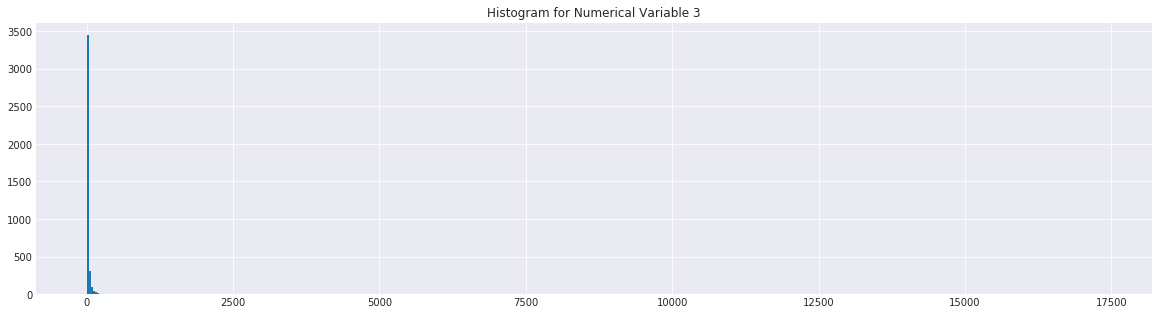

In [124]:
catVarNum = 2
numeric_sample_df[catVarNum].hist(figsize=(20,5), bins=500)
plt.title("Histogram for Numerical Variable " + str(catVarNum+1))
plt.show()

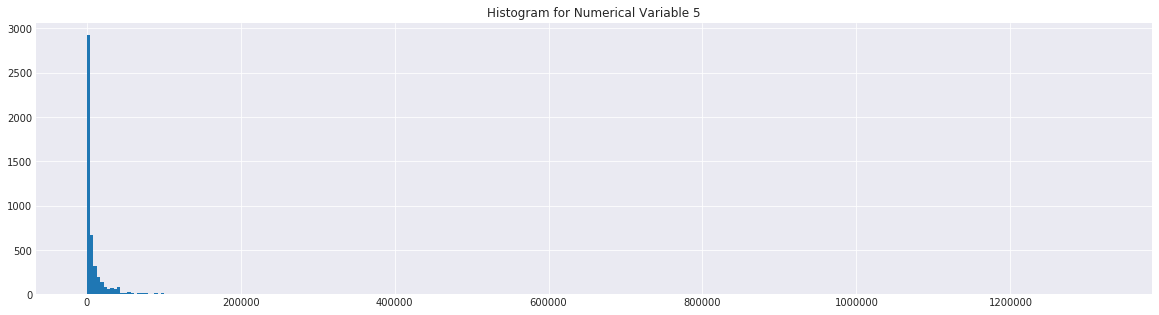

In [105]:
catVarNum = 4
numeric_sample_df[catVarNum].hist(figsize=(20,5), bins=300)
plt.title("Histogram for Numerical Variable " + str(catVarNum+1))
plt.show()

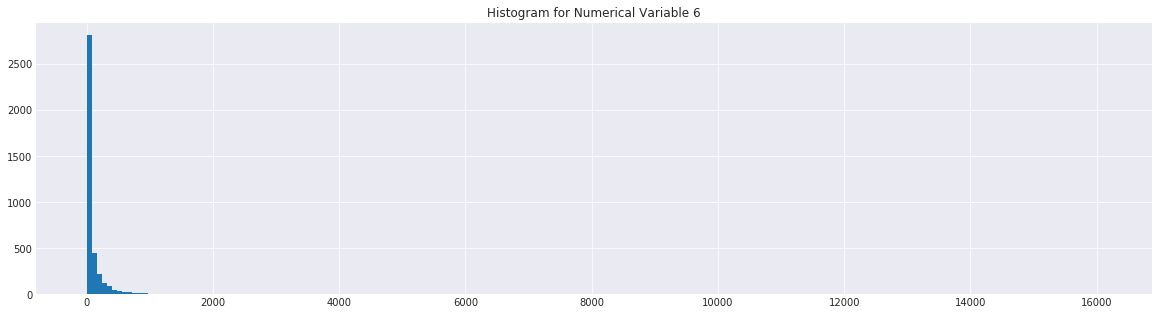

In [106]:
catVarNum = 5
numeric_sample_df[catVarNum].hist(figsize=(20,5), bins=200)
plt.title("Histogram for Numerical Variable " + str(catVarNum+1))
plt.show()

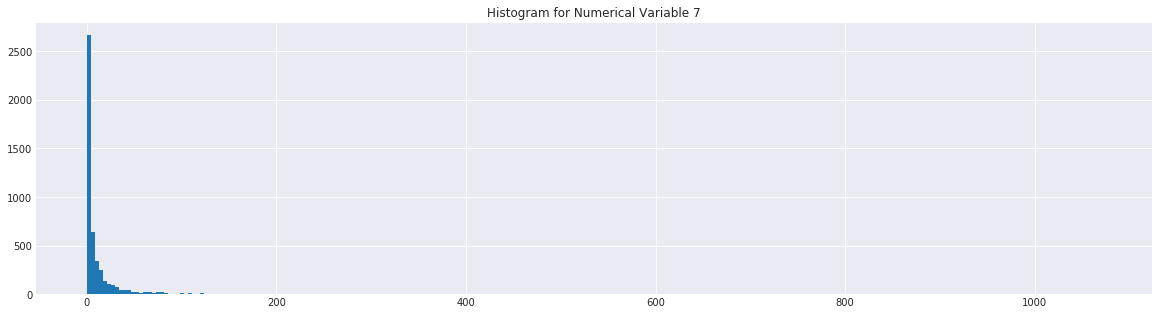

In [107]:
catVarNum = 6
numeric_sample_df[catVarNum].hist(figsize=(20,5), bins=250)
plt.title("Histogram for Numerical Variable " + str(catVarNum+1))
plt.show()

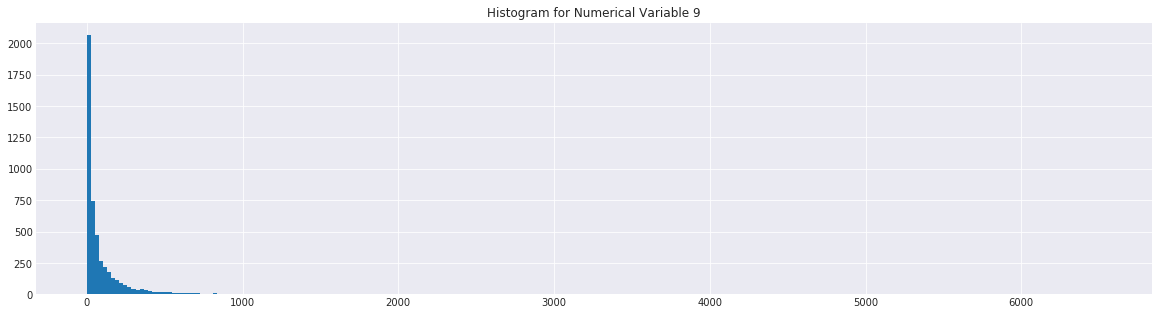

In [108]:
catVarNum = 8
numeric_sample_df[catVarNum].hist(figsize=(20,5), bins=250)
plt.title("Histogram for Numerical Variable " + str(catVarNum+1))
plt.show()

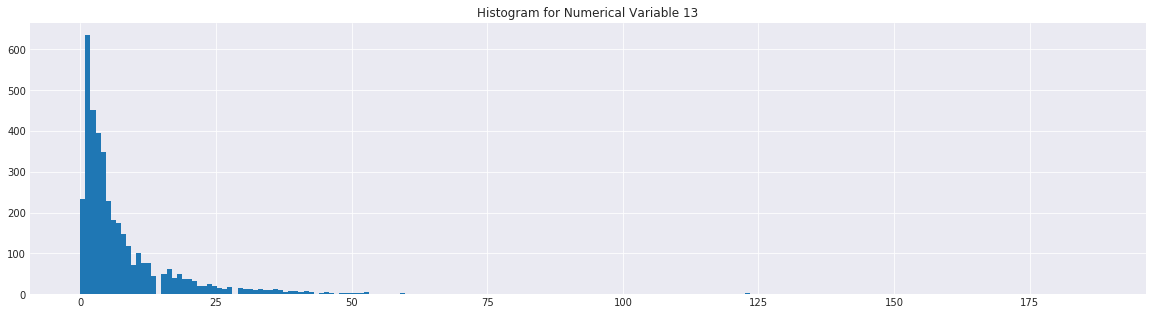

In [109]:
catVarNum = 12
numeric_sample_df[catVarNum].hist(figsize=(20,5), bins=200)
plt.title("Histogram for Numerical Variable " + str(catVarNum+1))
plt.show()

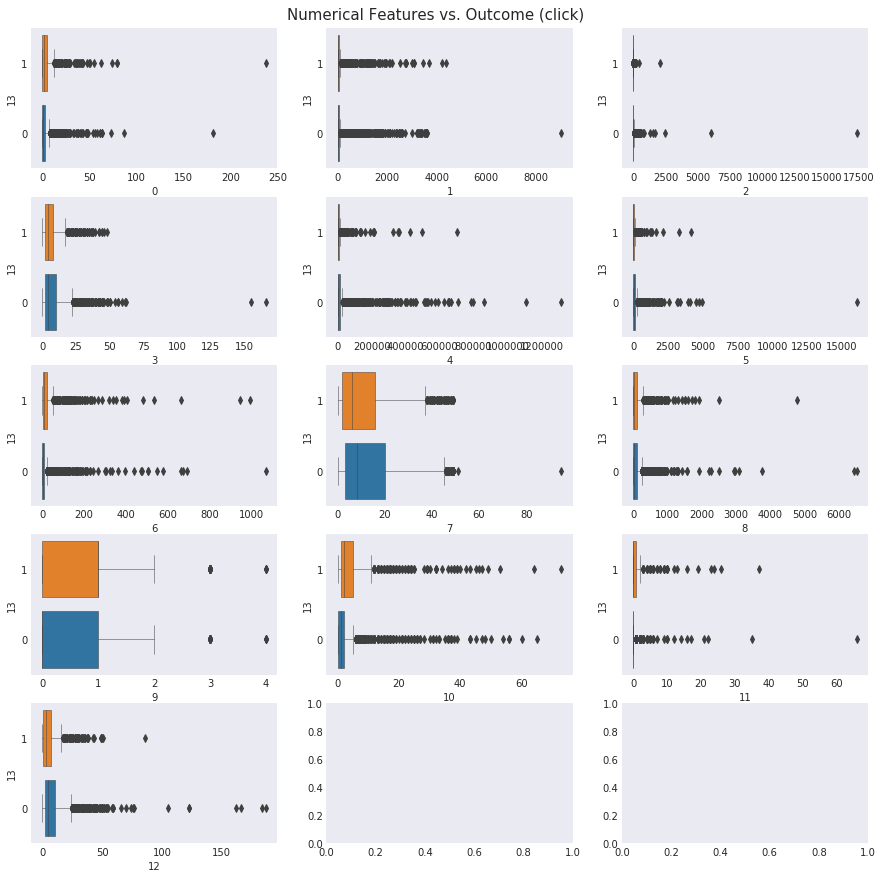

In [110]:
fig, ax_grid = plt.subplots(5, 3, figsize=(15,15))
y = numeric_sample_df.loc[:,13]#.astype("float")
for idx in range(len(numeric_sample_df.columns)-1):
    x = numeric_sample_df.loc[:,idx]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("Numerical Features vs. Outcome (click)", fontsize=15, y=0.9)
plt.show()

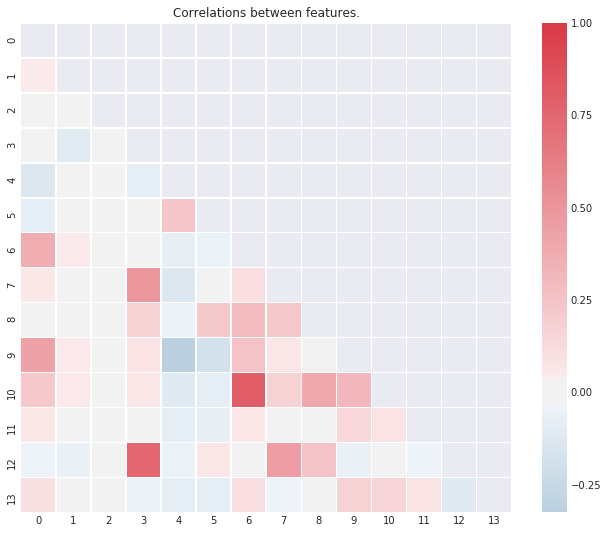

In [111]:
corr = numeric_sample_df.loc[:,:14].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

### Log Transform

In [112]:
small_constant = 0.001
log_numeric_sample_df = numeric_sample_df.apply(lambda x: x+small_constant).apply(np.log)

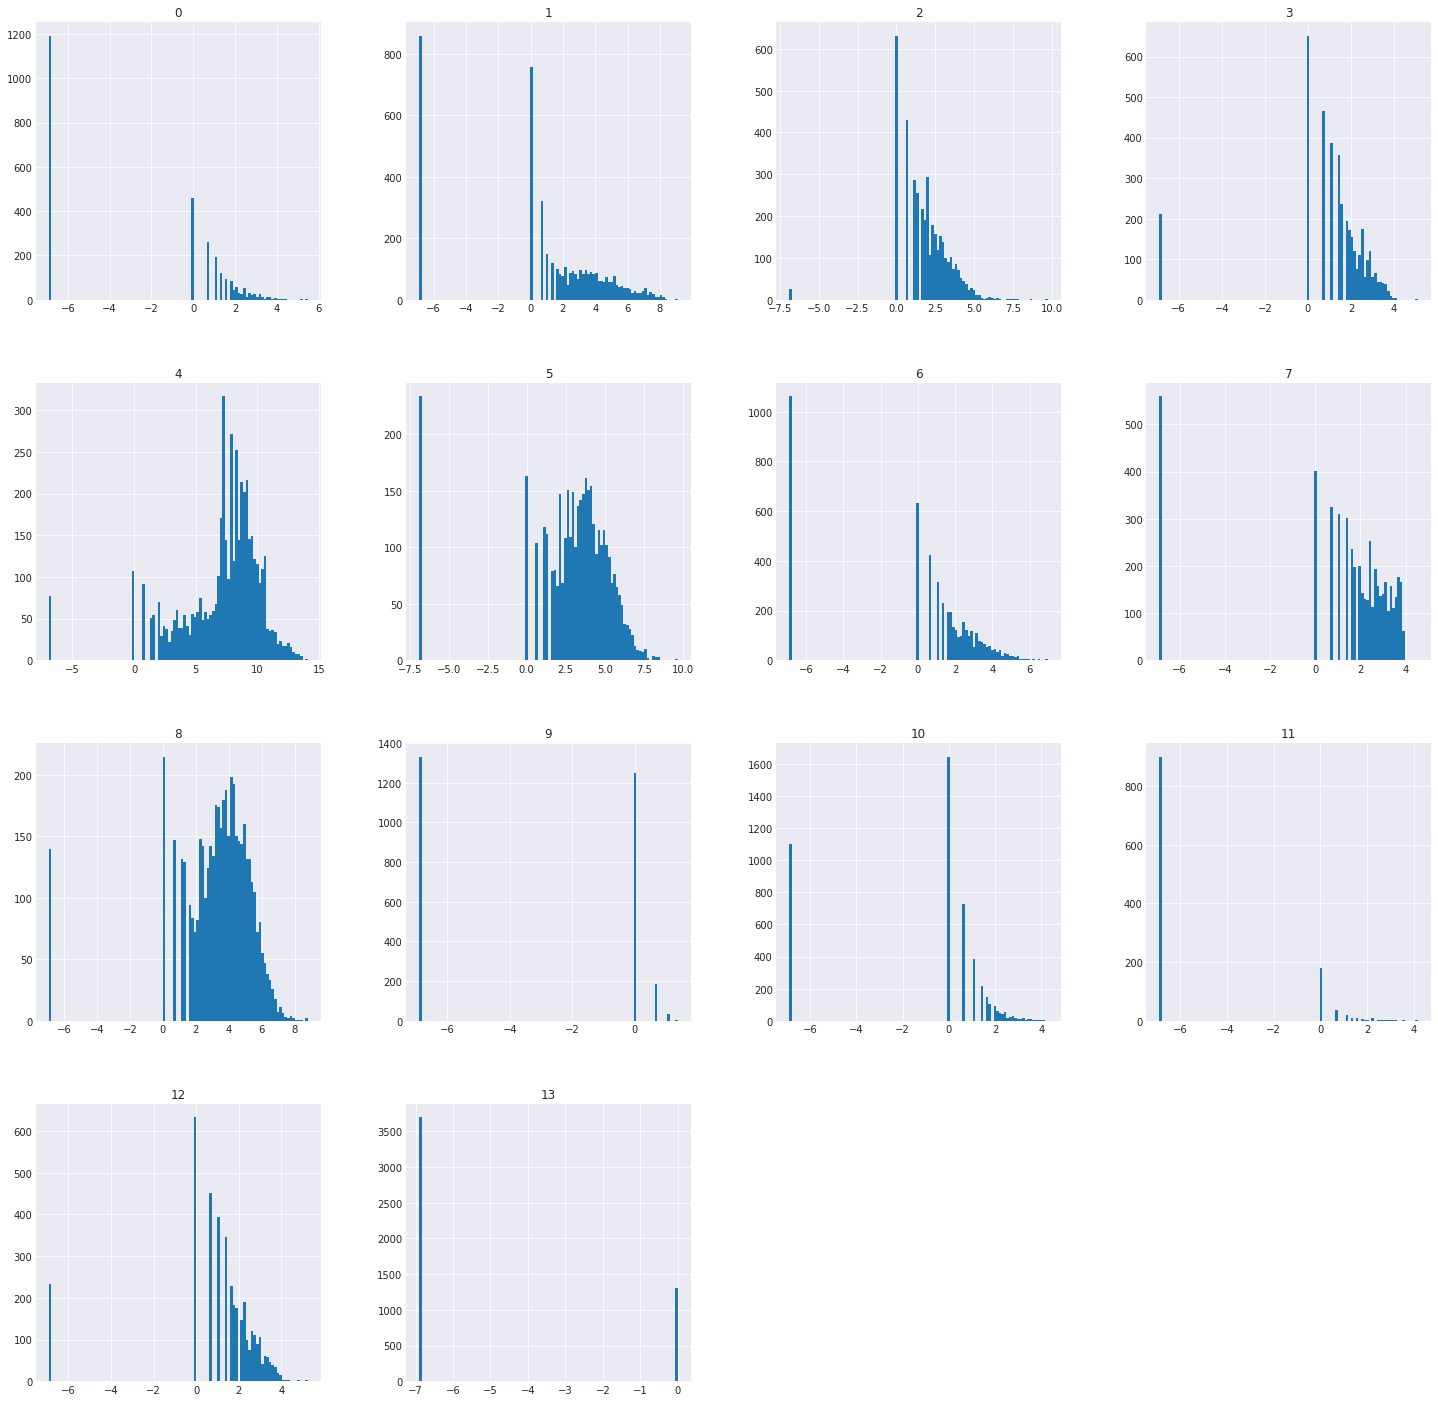

In [113]:
log_numeric_sample_df.hist(figsize=(25,25), bins=100)
plt.show()

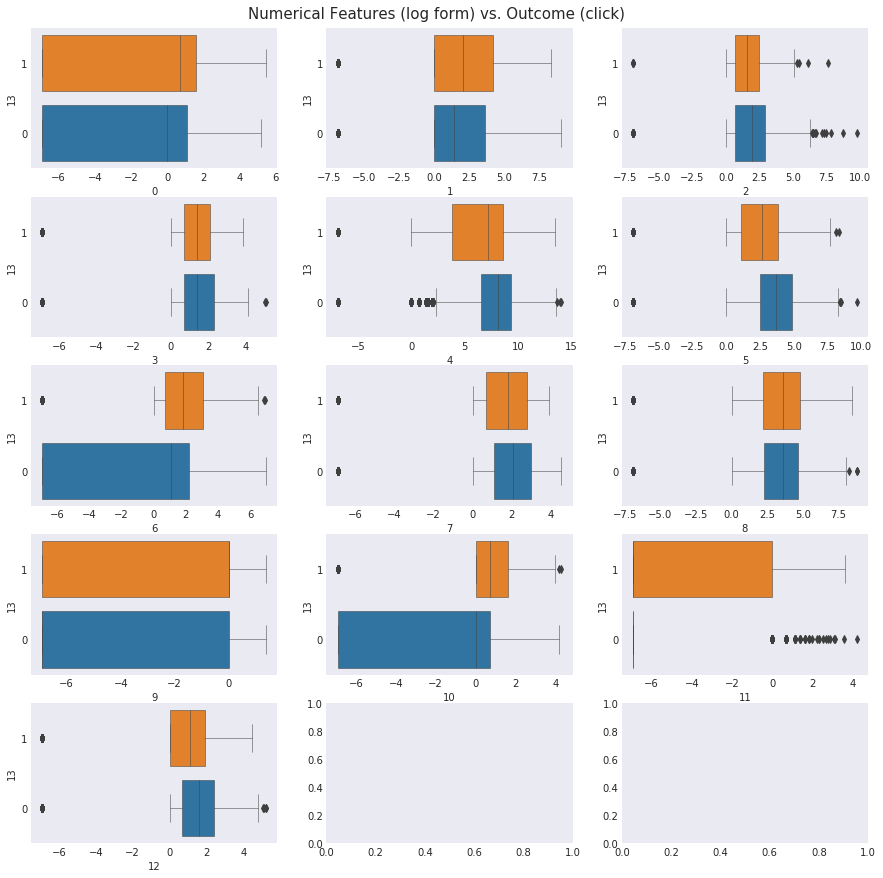

In [114]:
fig, ax_grid = plt.subplots(5, 3, figsize=(15,15))
y = numeric_sample_df.loc[:,13]#.astype("float")
for idx in range(len(numeric_sample_df.columns)-1):
    x = log_numeric_sample_df.loc[:,idx]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("Numerical Features (log form) vs. Outcome (click)", fontsize=15, y=0.9)
plt.show()

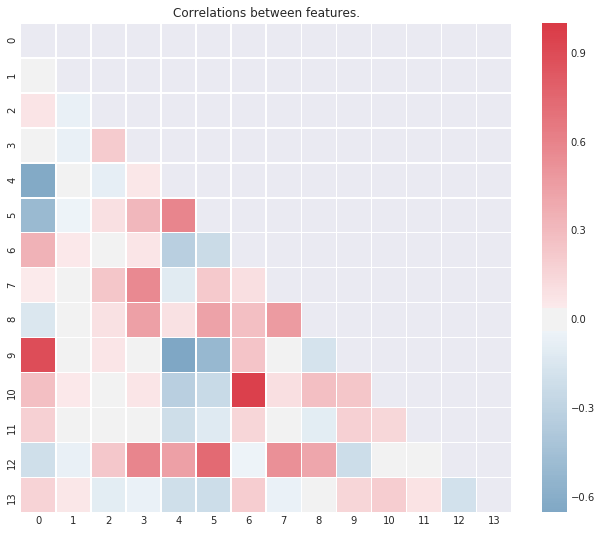

In [115]:
corr = log_numeric_sample_df.loc[:,:14].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

## How many distinct values are there in each of the categories?

In [ ]:
for feature_num in range(len(categorical_sample_df.columns)):
    print(categorical_sample_df.loc[:,feature_num].unique())

In [ ]:
total_categories = 0
for feature_num in range(len(categorical_sample_df.columns)):
    num_distinct = len(categorical_sample_df.loc[:,feature_num].unique())
    if feature_num < 26:
        total_categories += num_distinct
        print("Distinct values in categorical feature", str(feature_num+1) + ":", str(num_distinct))
print("Total categories in sample:", str(total_categories))

In [116]:
total_categories = 0
all_categorical_values = pd.Series()
for feature_num in range(len(categorical_sample_df.columns)):
    distinct_values = categorical_sample_df.loc[:,feature_num].unique()
    num_distinct = len(distinct_values)
    all_categorical_values= all_categorical_values.append(pd.Series(distinct_values))
    if '55dd3565' in distinct_values:
        print("Duplicate of 55dd3565 found in feature",feature_num+1)
    if feature_num < 26:
        total_categories += num_distinct
        print("Distinct values in categorical feature", str(feature_num+1) + ":", str(num_distinct))
print("Total categories in sample:", str(total_categories))

Distinct values in categorical feature 1: 118
Distinct values in categorical feature 2: 331
Distinct values in categorical feature 3: 3255
Distinct values in categorical feature 4: 2449
Distinct values in categorical feature 5: 42
Distinct values in categorical feature 6: 9
Distinct values in categorical feature 7: 2223
Distinct values in categorical feature 8: 67
Distinct values in categorical feature 9: 2
Distinct values in categorical feature 10: 2088
Distinct values in categorical feature 11: 1558
Distinct values in categorical feature 12: 3083
Distinct values in categorical feature 13: 1328
Distinct values in categorical feature 14: 23
Distinct values in categorical feature 15: 1485
Distinct values in categorical feature 16: 2809
Distinct values in categorical feature 17: 9
Distinct values in categorical feature 18: 888
Duplicate of 55dd3565 found in feature 19
Distinct values in categorical feature 19: 361
Distinct values in categorical feature 20: 4
Distinct values in categorica

### Check for Duplicates

In [33]:
all_categorical_values[all_categorical_values.duplicated()]

34            
4             
34            
34            
1             
2             
34            
0             
8     55dd3565
32            
2             
2             
dtype: object

In [34]:
all_categorical_values[all_categorical_values=='55dd3565']

6    55dd3565
8    55dd3565
dtype: object

In [36]:
all_categorical_values[all_categorical_values=='']

34    
34    
4     
34    
34    
1     
2     
34    
0     
32    
2     
2     
dtype: object

/opt/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


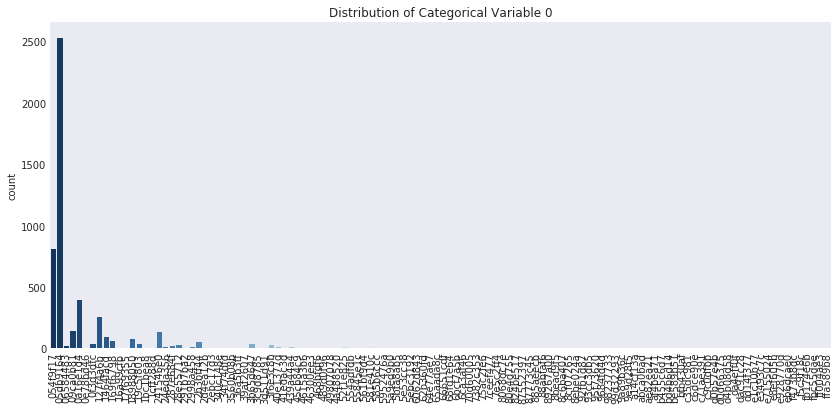

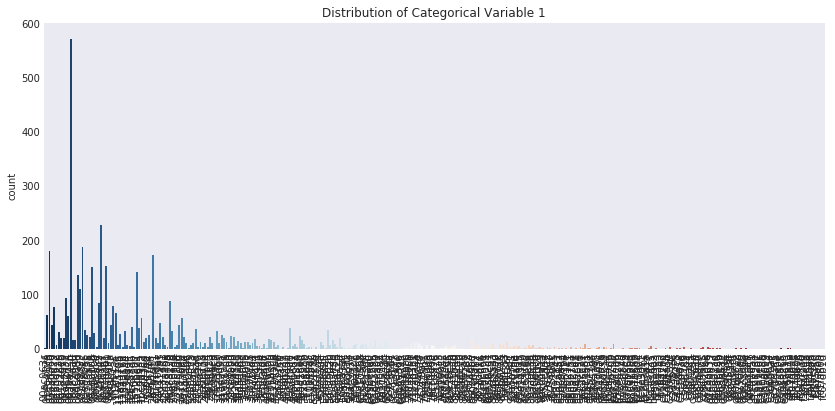

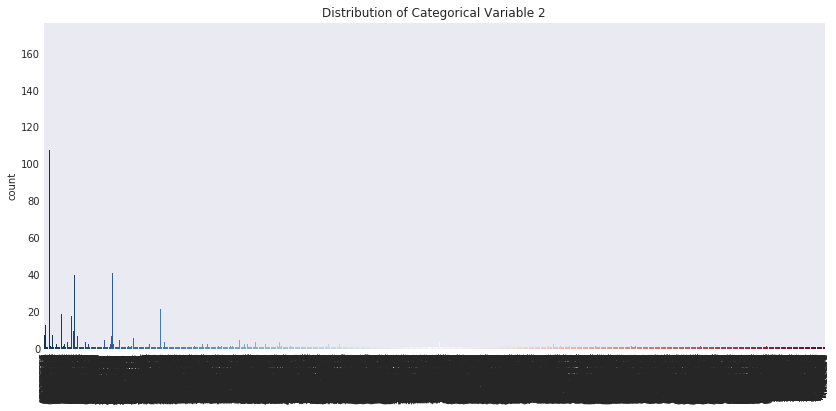

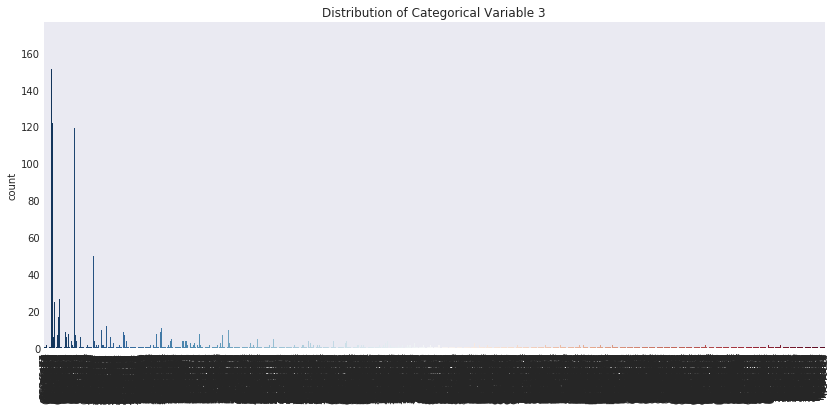

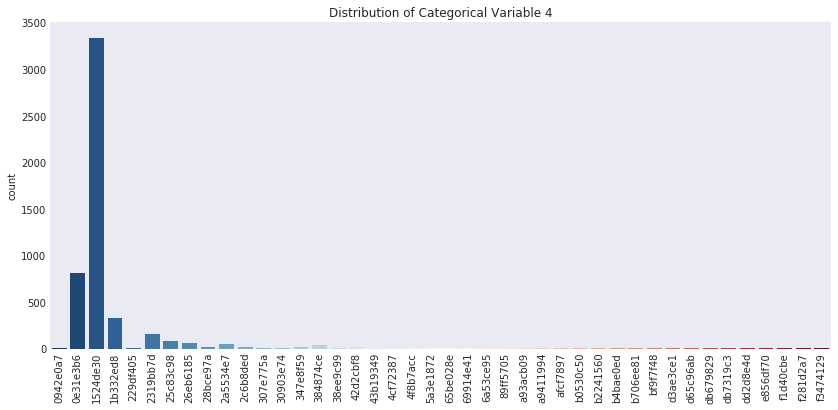

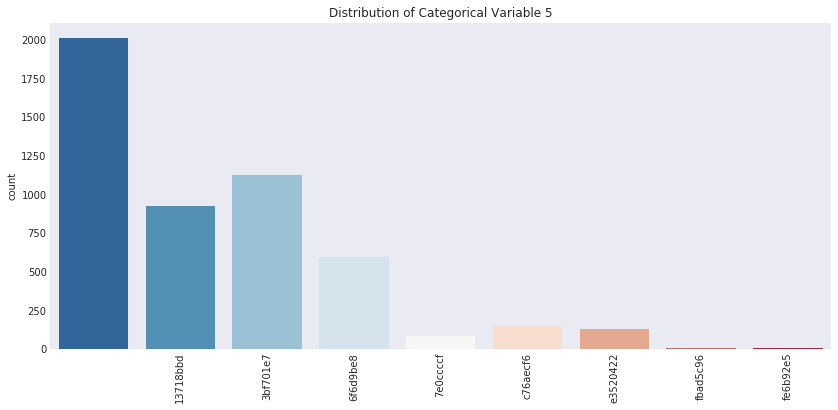

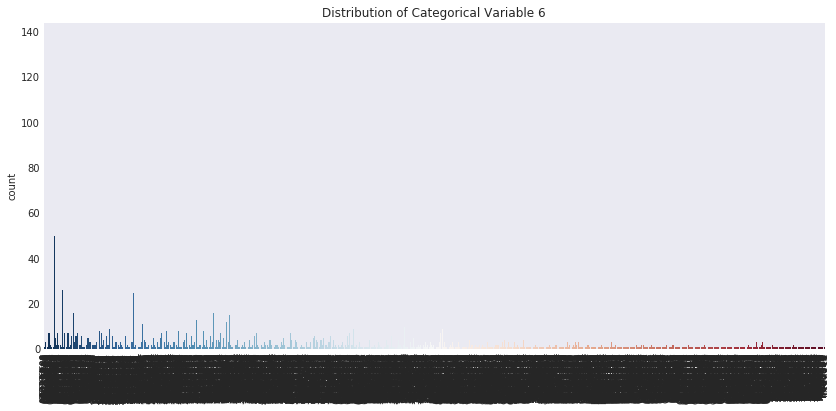

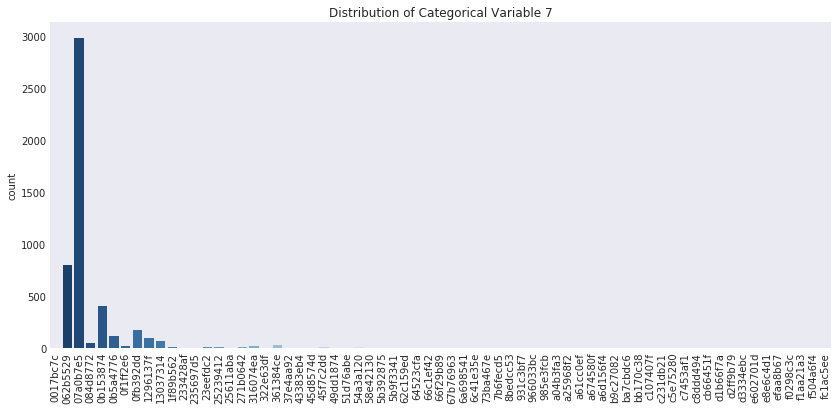

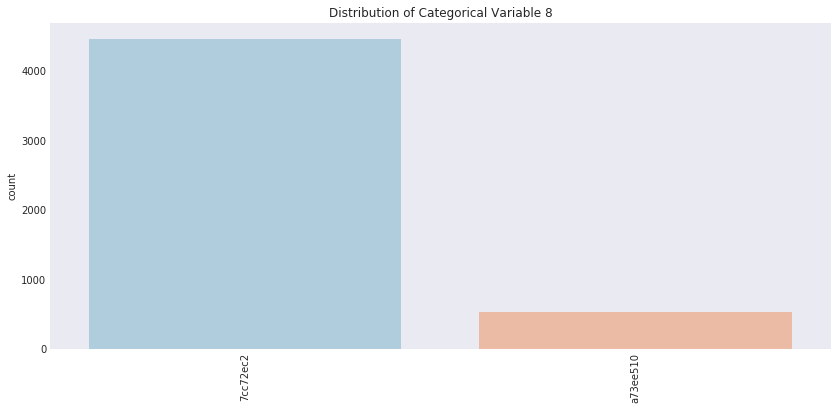

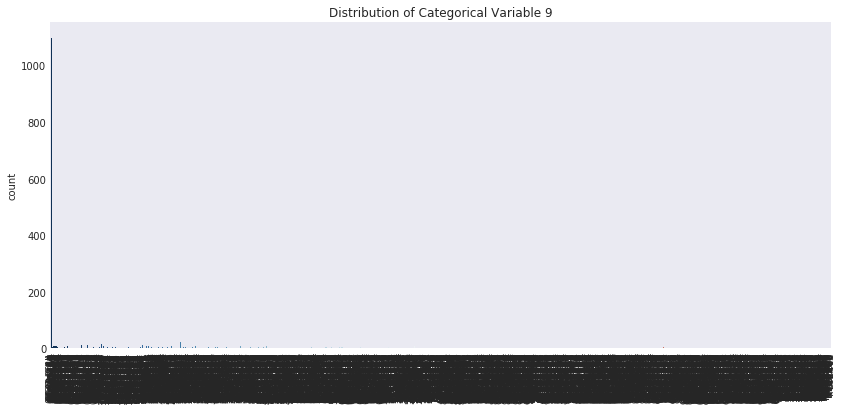

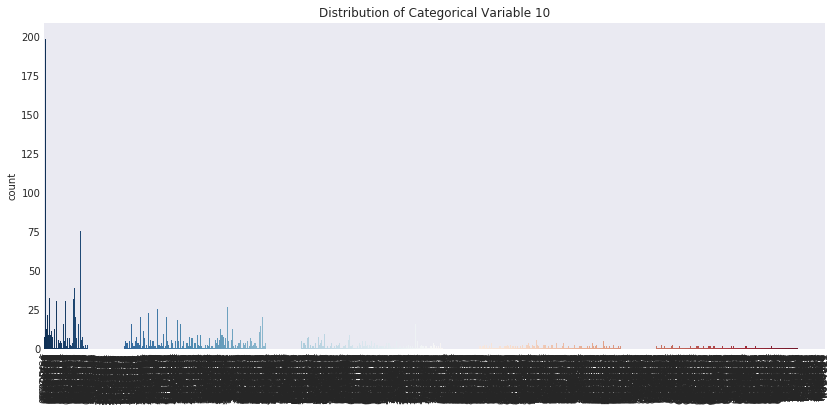

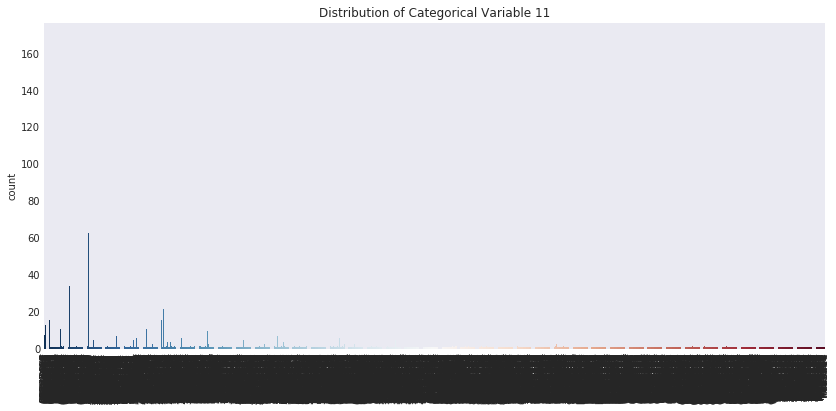

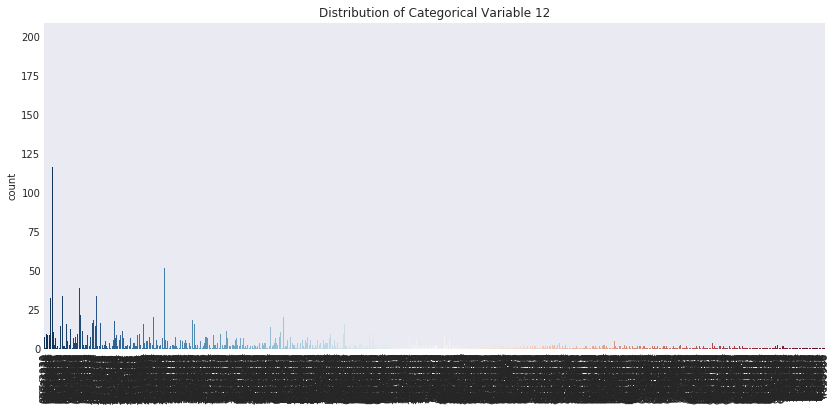

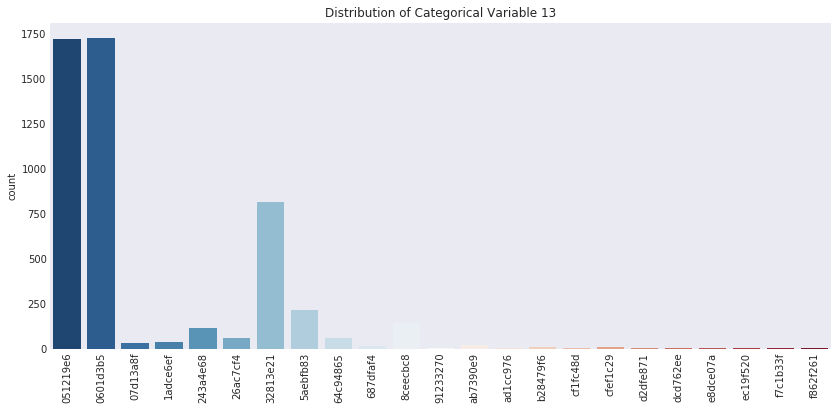

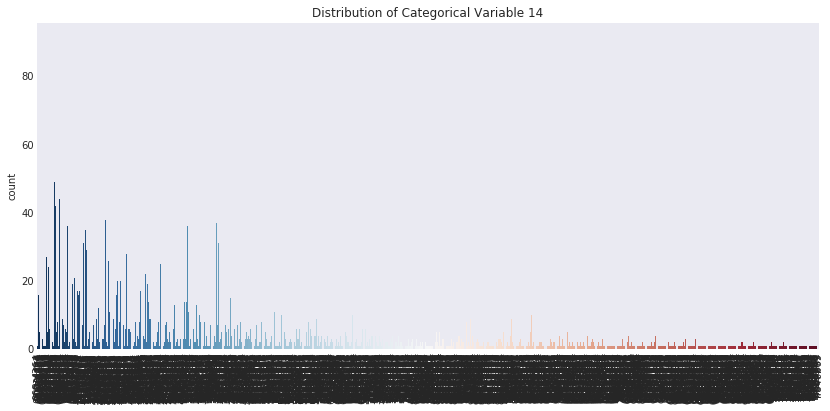

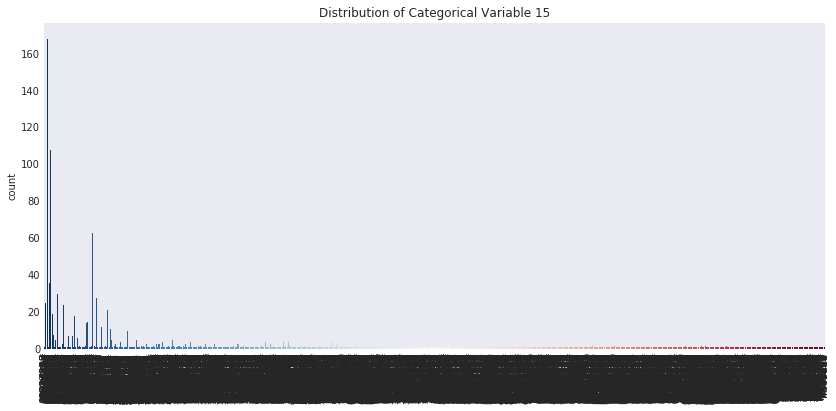

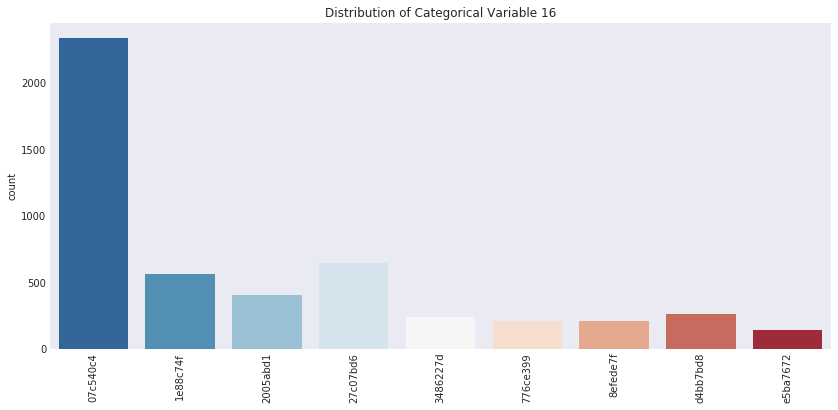

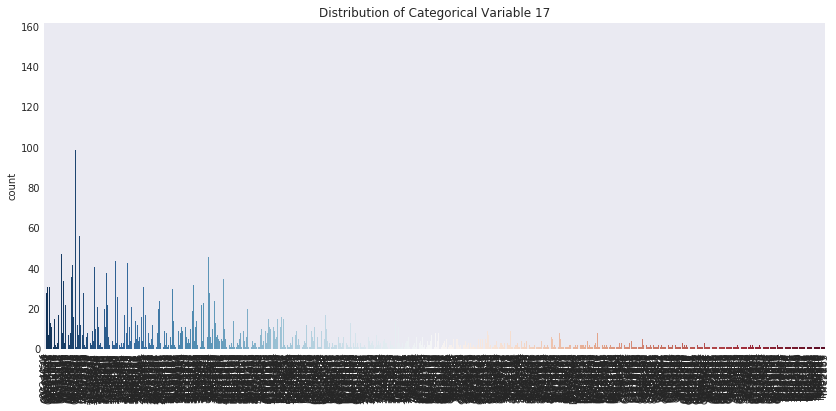

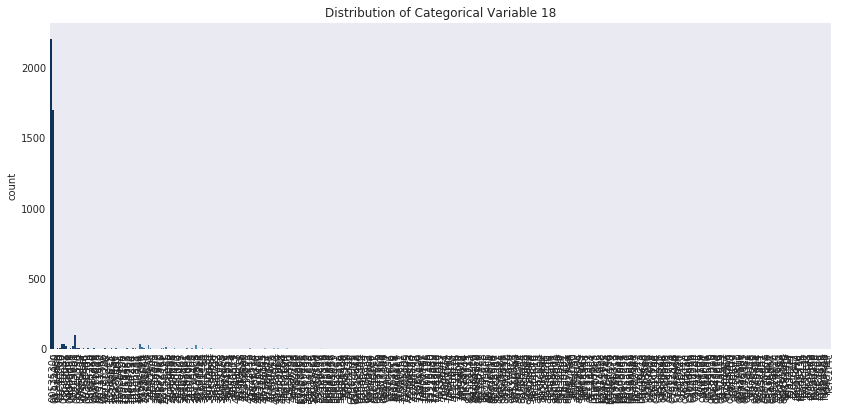

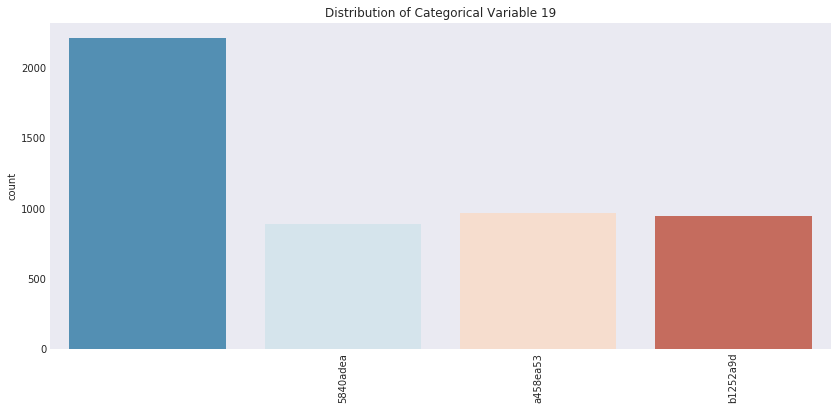

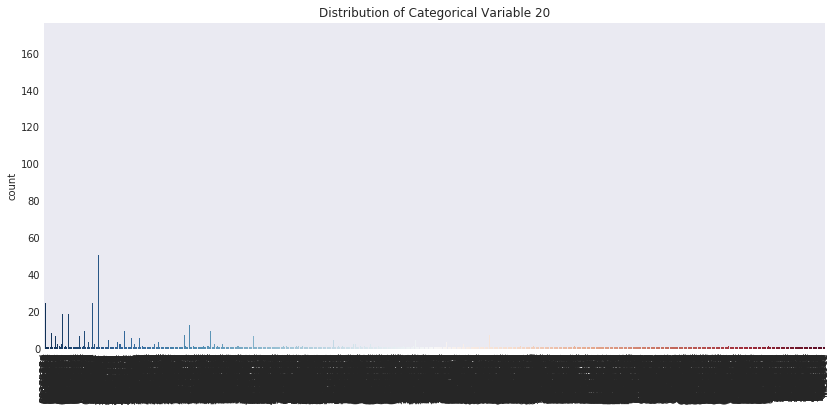

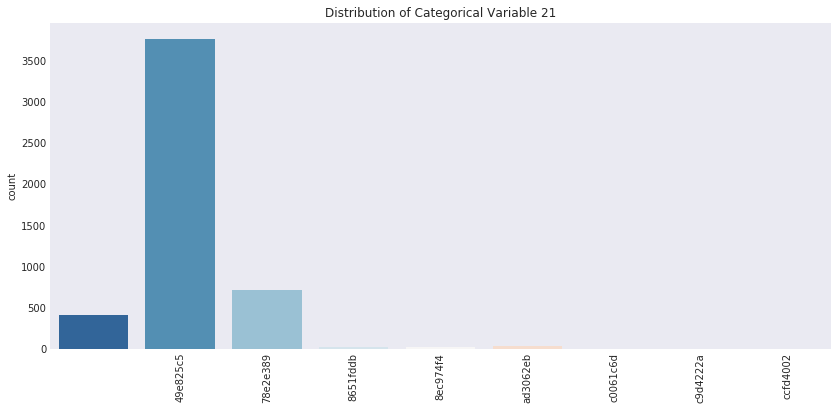

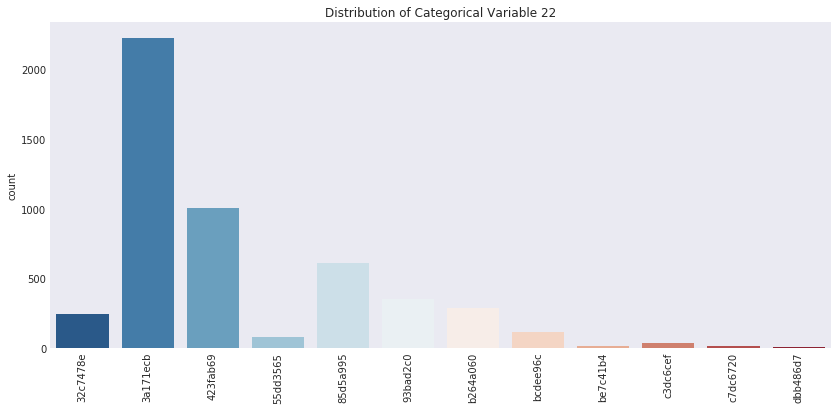

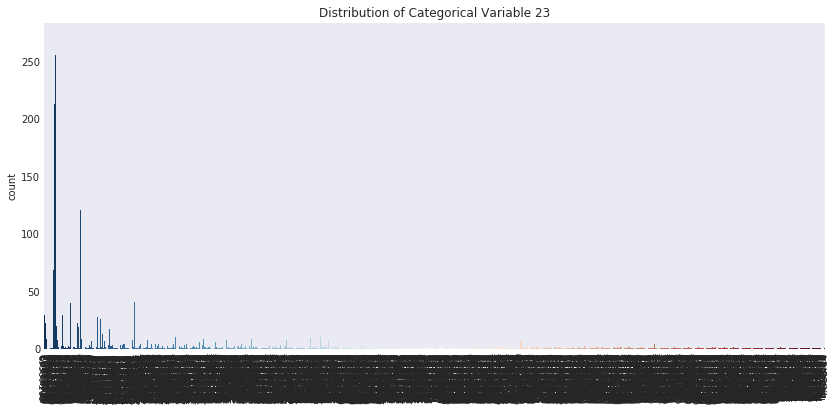

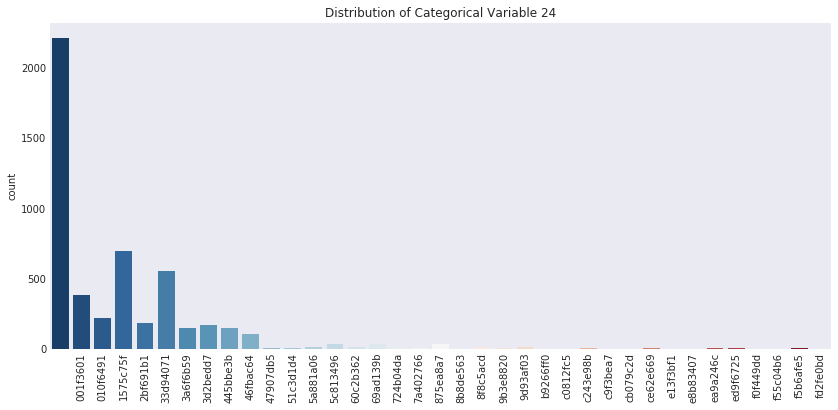

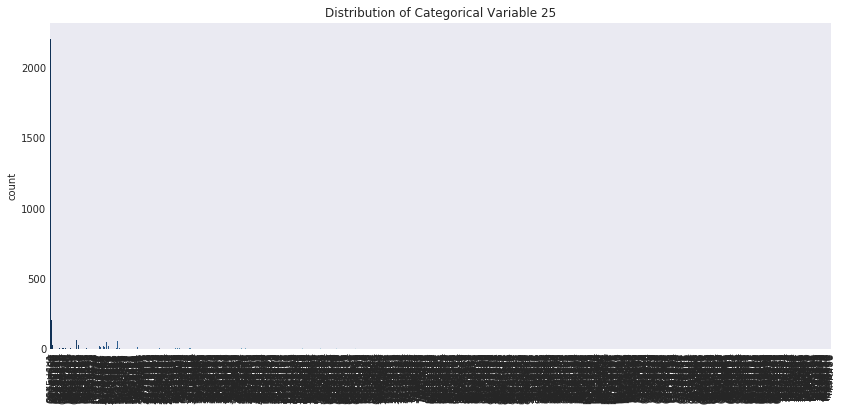

In [117]:
for idx in range(len(categorical_sample_df.columns)-1):
    columnName = categorical_sample_df.columns[idx]
    labels = np.unique(categorical_sample_df[columnName].values)
    fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot(111)
    #sns.countplot(x=categorical_sample_df[columnName].values,hue="certified",data=categorical_sample_df, palette="RdBu_r")
    #ax.set_xticklabels(labels, fontsize=12, rotation=90)
    sns.countplot(x=categorical_sample_df[columnName].values,data=categorical_sample_df, palette="RdBu_r")
    ax.set_xticklabels(labels, rotation=90)
    ax.set_title("Distribution of Categorical Variable " + str(columnName))

/opt/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


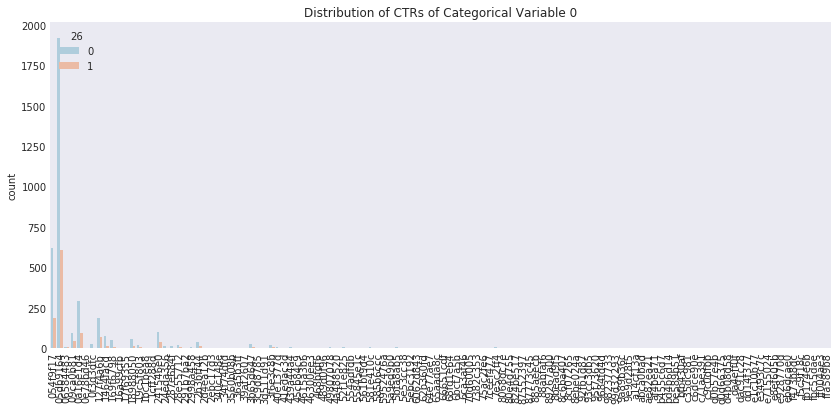

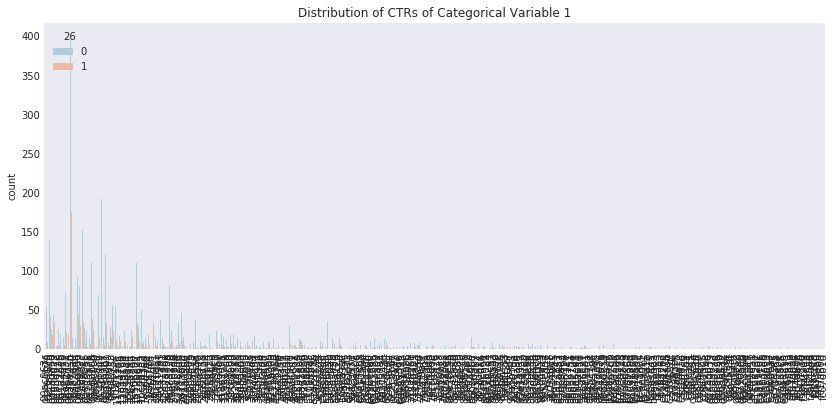

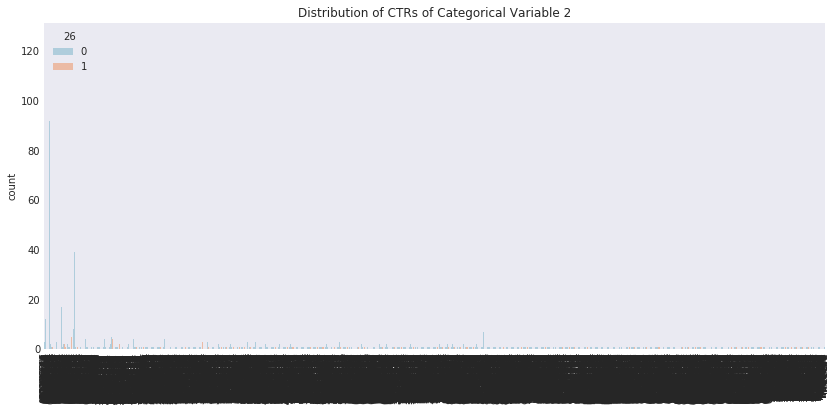

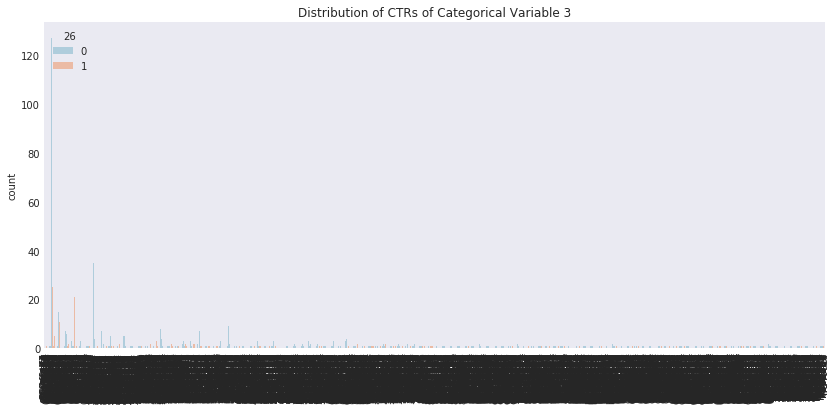

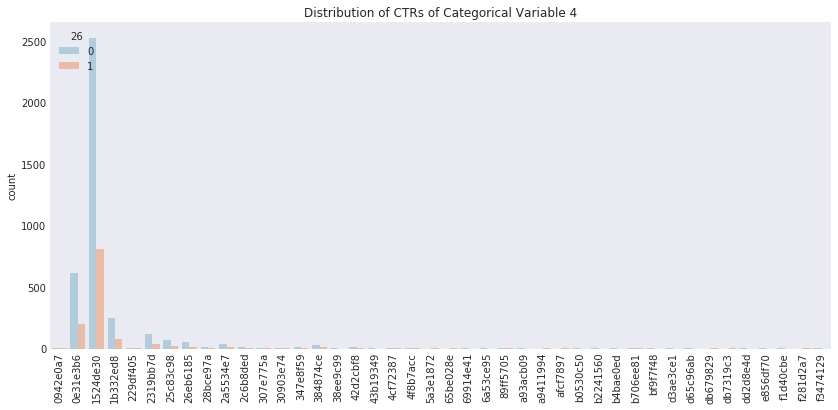

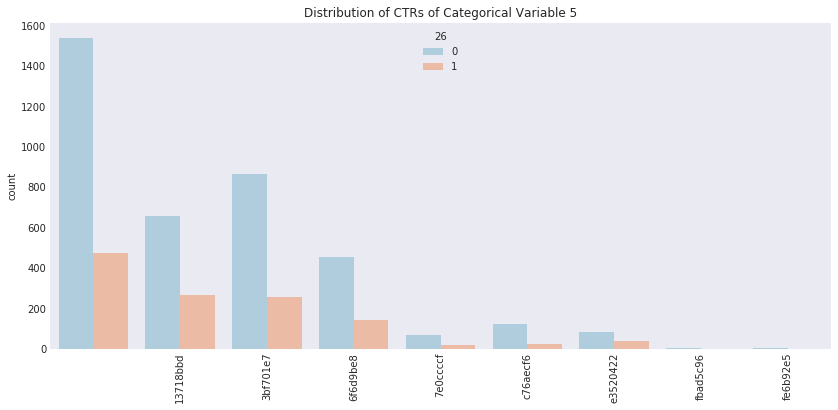

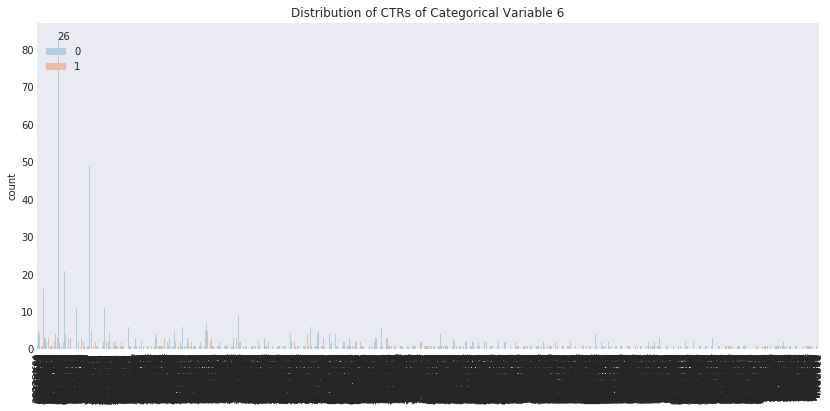

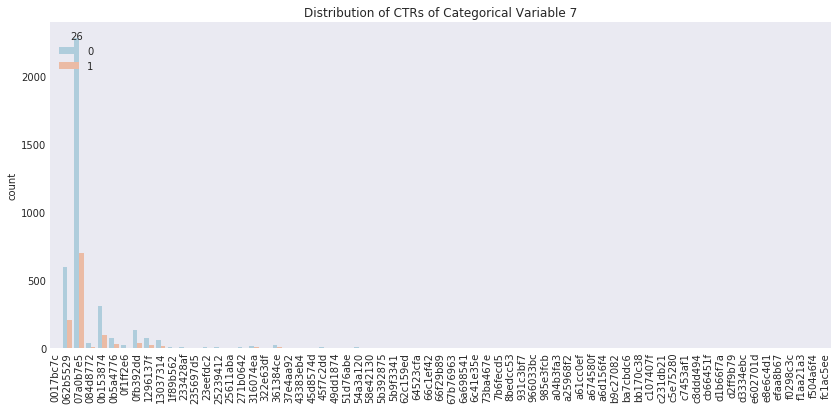

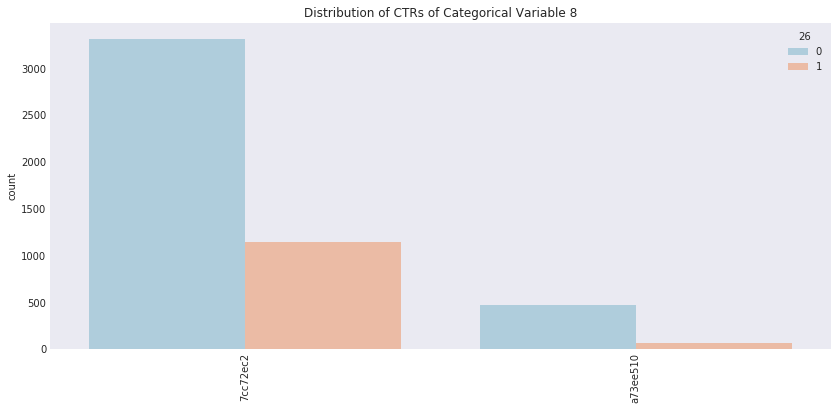

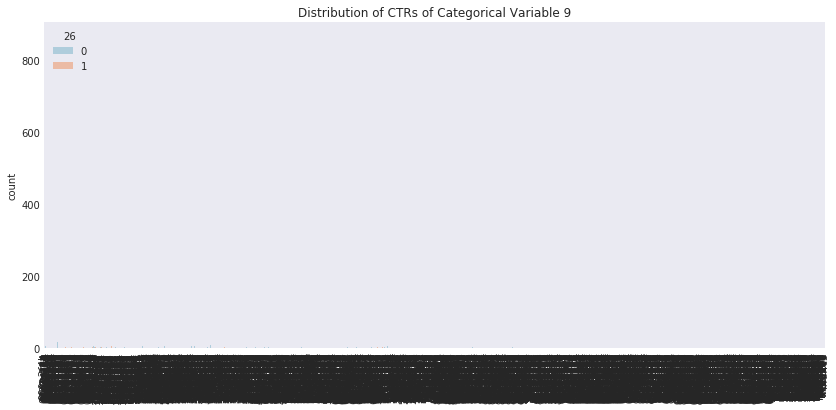

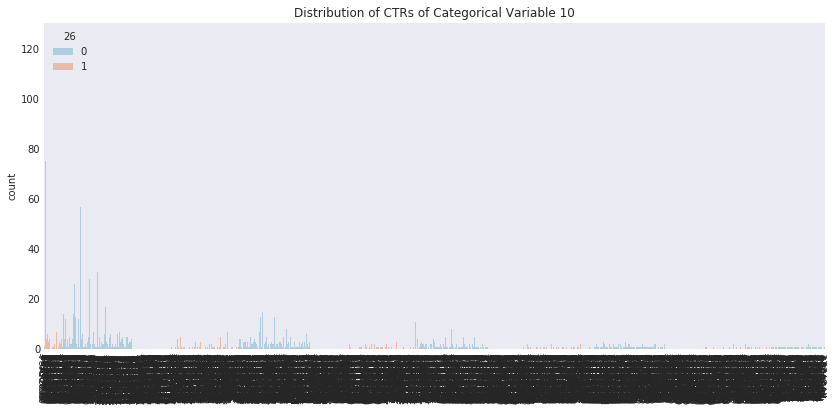

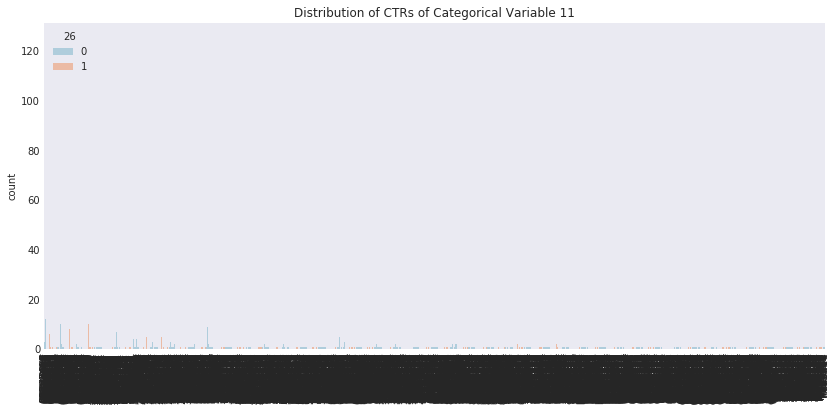

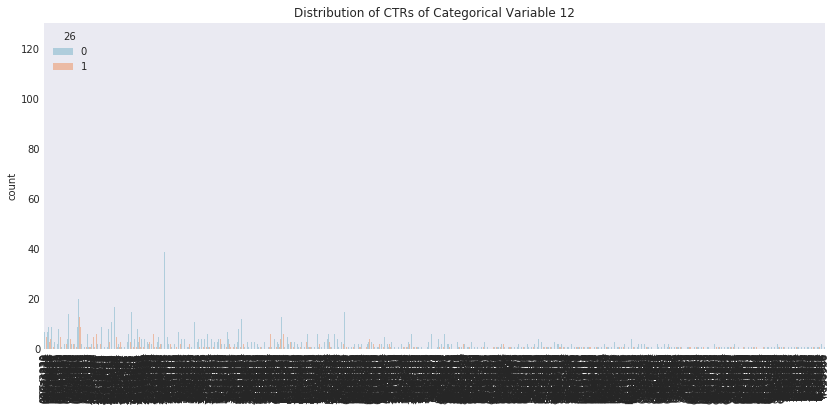

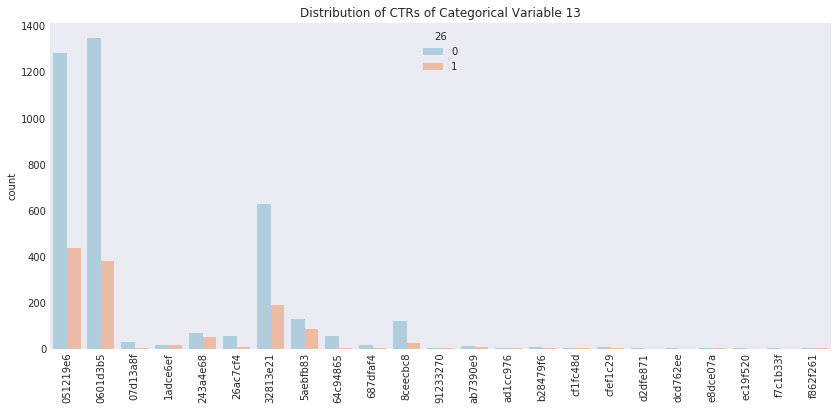

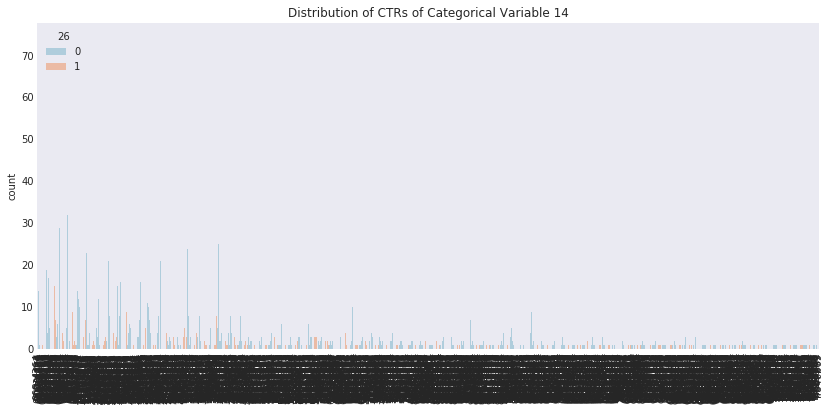

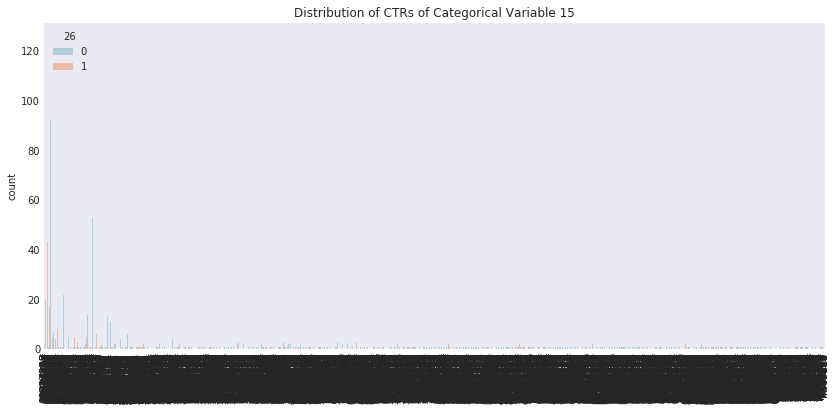

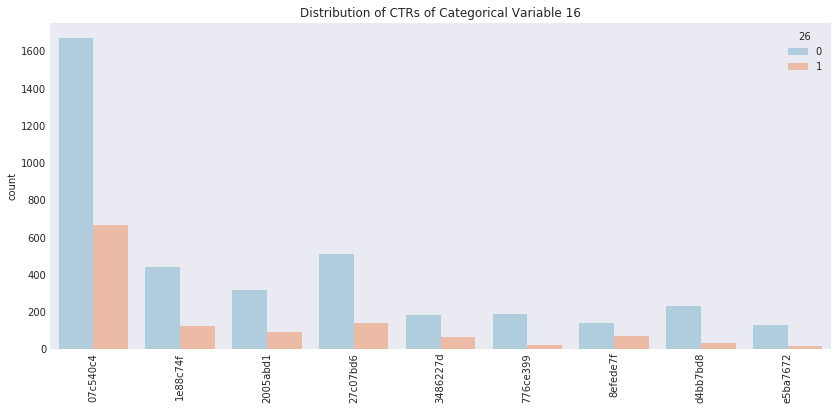

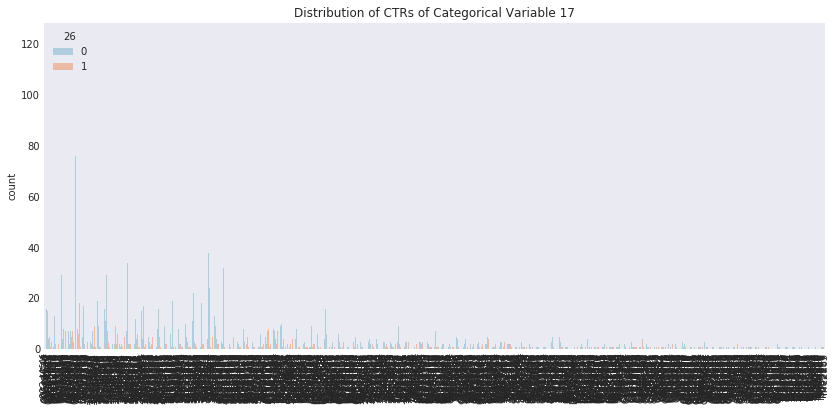

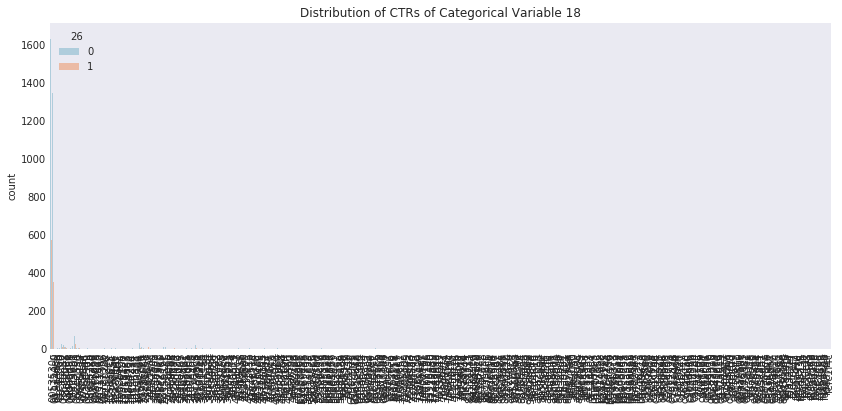

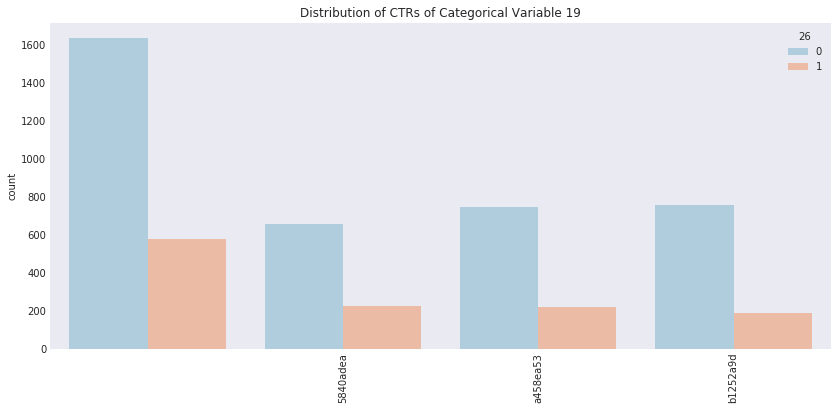

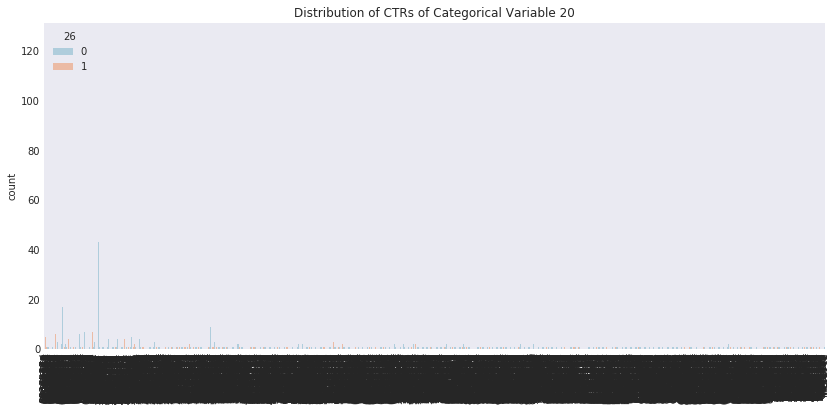

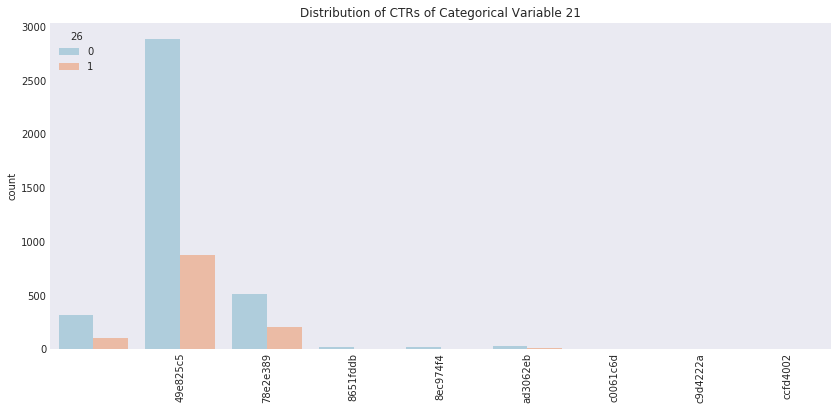

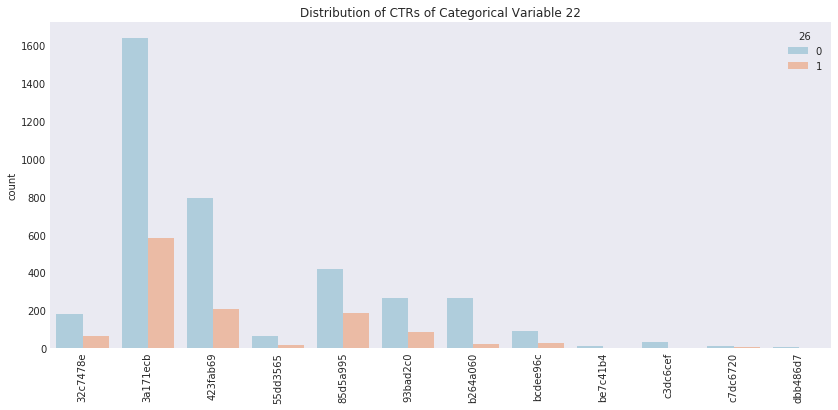

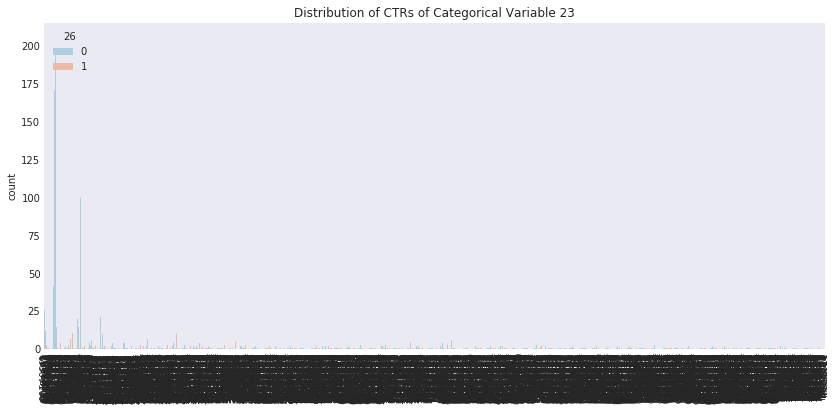

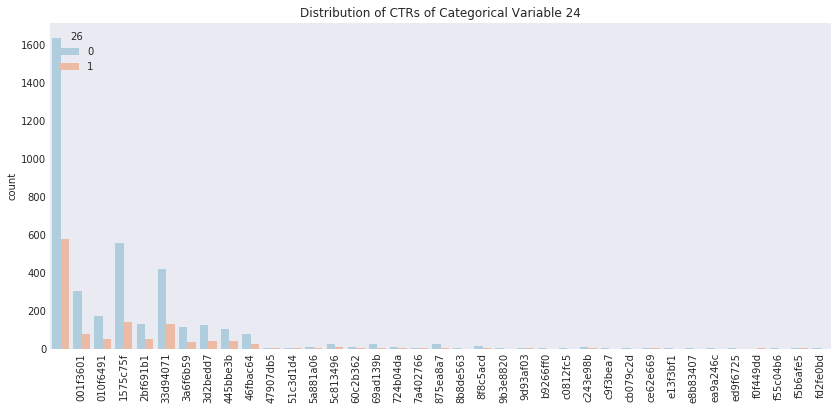

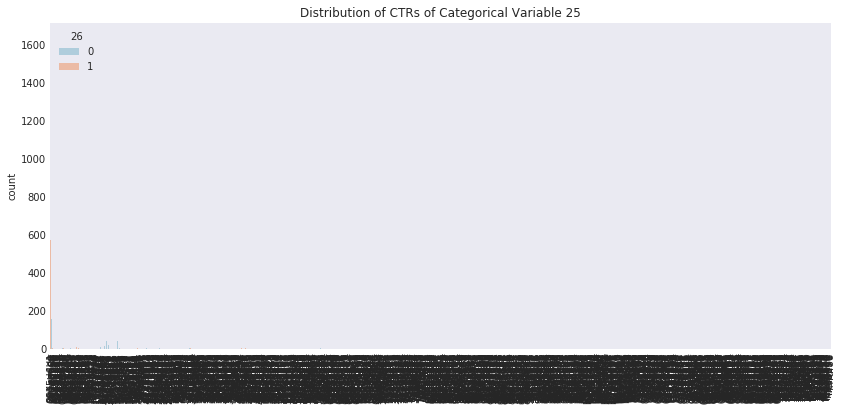

In [118]:
for idx in range(len(categorical_sample_df.columns)-1):
    columnName = categorical_sample_df.columns[idx]
    labels = np.unique(categorical_sample_df[columnName].values)
    fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot(111)
    #sns.countplot(x=categorical_sample_df[columnName].values,hue="certified",data=categorical_sample_df, palette="RdBu_r")
    #ax.set_xticklabels(labels, fontsize=12, rotation=90)
    sns.countplot(x=categorical_sample_df[columnName].values,data=categorical_sample_df, palette="RdBu_r", hue=26)
    ax.set_xticklabels(labels, rotation=90)
    ax.set_title("Distribution of CTRs of Categorical Variable " + str(columnName))

## Transformation

In [7]:
sampleRDD1, sampleRDD2 = original_trainRDD.randomSplit([0.9999,0.0001], seed = 1)
test_trainRDDCached = sampleRDD2.map(parse).cache()
test_trainRDDCached.take(1)

[[nan,
  4.0,
  50.0,
  18.0,
  3339.0,
  20.0,
  26.0,
  17.0,
  133.0,
  nan,
  2.0,
  nan,
  18.0,
  '0_09ca0b81',
  '1_09e68b86',
  '2_86c4b829',
  '3_e3d0459f',
  '4_25c83c98',
  '5_MISSINGVALUE',
  '6_7227c706',
  '7_0b153874',
  '8_a73ee510',
  '9_305a0646',
  '10_9625b211',
  '11_997a695a',
  '12_dccbd94b',
  '13_07d13a8f',
  '14_36721ddc',
  '15_c0b906bb',
  '16_e5ba7672',
  '17_5aed7436',
  '18_21ddcdc9',
  '19_a458ea53',
  '20_0cbbcc92',
  '21_MISSINGVALUE',
  '22_32c7478e',
  '23_0174dd24',
  '24_3d2bedd7',
  '25_d8ecbc17',
  0]]

In [8]:
ncol = len(test_trainRDDCached.first())
nrow = test_trainRDDCached.count()

In [9]:
nrow

4478

In [10]:
distinctValsRDD = test_trainRDDCached.flatMap(lambda line: line[13:-1]).distinct()
distinctValsRDD.count()

25676

### What is the percentage of NaN values in each numerical feature?

In [28]:
nanCounts = numericalFeatures.map(lambda line: 1.0*np.isnan(line)).reduce(lambda x,y: np.add(x,y))
nanCounts

array([1.978e+03, 0.000e+00, 9.580e+02, 9.220e+02, 1.220e+02, 9.710e+02,
       1.870e+02, 1.000e+00, 1.870e+02, 1.978e+03, 1.870e+02, 3.375e+03,
       9.220e+02])

In [36]:
nonNanCounts = numericalFeatures.map(lambda line: 1.0*~np.isnan(line)).reduce(lambda x,y: np.add(x,y))
nonNanCounts
#nonNanCountsb = sc.broadcast(nonNanCounts)

In [35]:
np.round(100*np.divide(nanCounts, np.add(nanCounts, nonNanCounts)),1)

array([44.2,  0. , 21.4, 20.6,  2.7, 21.7,  4.2,  0. ,  4.2, 44.2,  4.2,
       75.4, 20.6])

In [91]:
# part d - helper function to normalize the data (FILL IN THE MISSING CODE BELOW)
def normalize(dataRDD):
    """
    Scale and center data round mean of each feature.
    Args:
        dataRDD - records are tuples of (features_array, y)
    Returns:
        normedRDD - records are tuples of (features_array, y)
    """
    translation_after_standardization = 5

    numericalFeatures = dataRDD.map(lambda x: list(x[:13])).cache()

    nonNanCounts = numericalFeatures.map(lambda line: 1.0*~np.isnan(line)).reduce(lambda x,y: np.add(x,y))
    nonNanCountsb = sc.broadcast(nonNanCounts)
    
    featureMeans = numericalFeatures.reduce(lambda x,y: np.nansum(np.dstack((x, y)), 2))
    featureMeans = np.divide(featureMeans,nonNanCountsb.value)
    featureMeansb = sc.broadcast(featureMeans)
    
    featureStdev = numericalFeatures.map(lambda line: np.square(np.subtract(line, featureMeansb.value))) \
                                    .reduce(lambda x,y: np.nansum(np.dstack((x, y)), 2))
    featureStdev = np.sqrt(featureStdev/nonNanCountsb.value)
    featureStdevb = sc.broadcast(featureStdev)
    
    normedRDD = dataRDD.map(lambda x: np.add(np.divide(np.subtract(x[:13],featureMeansb.value),featureStdevb.value), translation_after_standardization).tolist()[0] + list(x[13:]))
    
    return normedRDD

In [92]:
# part d - cache normalized data (RUN THIS CELL AS IS)
normedRDD = normalize(test_trainRDDCached).cache()
#test_blah = normedRDD.first()

### Log Transform

In [97]:
logRDD = normedRDD.map(lambda x: np.log(x[:13]).tolist() + list(x[13:]))
#logRDD.first()

[nan,
 1.5546416330280177,
 1.614858026325336,
 1.8324388135638439,
 1.5658974261919119,
 1.5447893046000354,
 1.6455071185060295,
 1.6722403253403968,
 1.6258544971242836,
 nan,
 1.5791945292276104,
 nan,
 1.7750904691093639,
 '0_09ca0b81',
 '1_09e68b86',
 '2_86c4b829',
 '3_e3d0459f',
 '4_25c83c98',
 '5_MISSINGVALUE',
 '6_7227c706',
 '7_0b153874',
 '8_a73ee510',
 '9_305a0646',
 '10_9625b211',
 '11_997a695a',
 '12_dccbd94b',
 '13_07d13a8f',
 '14_36721ddc',
 '15_c0b906bb',
 '16_e5ba7672',
 '17_5aed7436',
 '18_21ddcdc9',
 '19_a458ea53',
 '20_0cbbcc92',
 '21_MISSINGVALUE',
 '22_32c7478e',
 '23_0174dd24',
 '24_3d2bedd7',
 '25_d8ecbc17',
 0]

### One-Hot Encoding

In [100]:
numerical_names = ["n00", "n01", "n02", "n03", "n04", "n05", "n06", "n07", "n08", "n09", "n10", "n11", "n12"]
category_vals = np.ones(24).tolist()

In [103]:
def convert_to_list_form(line):
    numbers = line[:13]
    categories = line[13:-1]
    label = line[-1]
    dict1 = dict(zip(numerical_names, numbers))
    dict2 = dict(zip(categories, category_vals))
    return (label, {**dict1, **dict2})

In [105]:
final_data_rdd = logRDD.map(convert_to_list_form)
final_data_rdd.first()

(0,
 {'n00': nan,
  'n01': 1.5546416330280177,
  'n02': 1.614858026325336,
  'n03': 1.8324388135638439,
  'n04': 1.5658974261919119,
  'n05': 1.5447893046000354,
  'n06': 1.6455071185060295,
  'n07': 1.6722403253403968,
  'n08': 1.6258544971242836,
  'n09': nan,
  'n10': 1.5791945292276104,
  'n11': nan,
  'n12': 1.7750904691093639,
  '0_09ca0b81': 1.0,
  '1_09e68b86': 1.0,
  '2_86c4b829': 1.0,
  '3_e3d0459f': 1.0,
  '4_25c83c98': 1.0,
  '5_MISSINGVALUE': 1.0,
  '6_7227c706': 1.0,
  '7_0b153874': 1.0,
  '8_a73ee510': 1.0,
  '9_305a0646': 1.0,
  '10_9625b211': 1.0,
  '11_997a695a': 1.0,
  '12_dccbd94b': 1.0,
  '13_07d13a8f': 1.0,
  '14_36721ddc': 1.0,
  '15_c0b906bb': 1.0,
  '16_e5ba7672': 1.0,
  '17_5aed7436': 1.0,
  '18_21ddcdc9': 1.0,
  '19_a458ea53': 1.0,
  '20_0cbbcc92': 1.0,
  '21_MISSINGVALUE': 1.0,
  '22_32c7478e': 1.0,
  '23_0174dd24': 1.0})